## Load model

In [33]:
import os
from utils_lib import utils
from utils_lib.etdata import ETData
from model import gazeNET as gazeNET
import model as model_func

logdir = os.path.join('logdir', 'model_final')
fname_config = os.path.join(logdir, 'config.json')
configuration = utils.Config(fname_config)
config = configuration.params

model_name = '%s.pth.tar' % 'gazeNET_0004_00003750'

num_classes = len(config['events'])
model = gazeNET(config, num_classes)
model_func.load(model, 'model_final', config, model_name)

logdir/model_final/models/gazeNET_0004_00003750.pth.tar
Loading model: logdir/model_final/models/gazeNET_0004_00003750.pth.tar
done.


('gazeNET_0004_00003750.pth.tar', 5)

## Load data

In [34]:
import numpy as np
from utils_lib.data_loader import EMDataset, GazeDataLoader
from utils_lib.etdata import get_px2deg

fpath = 'etdata/tobii/Kreuze_Random Recording1_short.npy'
fdir, fname = os.path.split(os.path.splitext(fpath)[0])

# load geometry
geom = {
    'screen_width': 16,
    'screen_height': 9,
    'display_width_pix': 1920,
    'display_height_pix': 1080,
    'eye_distance': 120,
}

# load trial data
X_test = np.load(fpath)

# # convert kartesian to polar coordinates
# px2deg = get_px2deg(geom)
# X_test['x'] = (X_test['x'] - geom['display_width_pix']/2) / px2deg
# X_test['y'] = (X_test['y'] - geom['display_height_pix']/2) / px2deg

# _status = np.isnan(X_test['x']) | \
#     np.isnan(X_test['y']) | \
#     ~np.in1d(X_test['evt'], config['events'])
# X_test['status'] = ~_status
test_dataset = EMDataset(config=config, gaze_data=[X_test])
n_samples = len(test_dataset)



[FP], n_samples: 145, dur: 0.29


/home/lorenz/gazeNet/utils_lib/etdata.py:225: RuntimeWarning: divide by zero encountered in divide
  t = np.median(1/np.diff(t[:-2]))


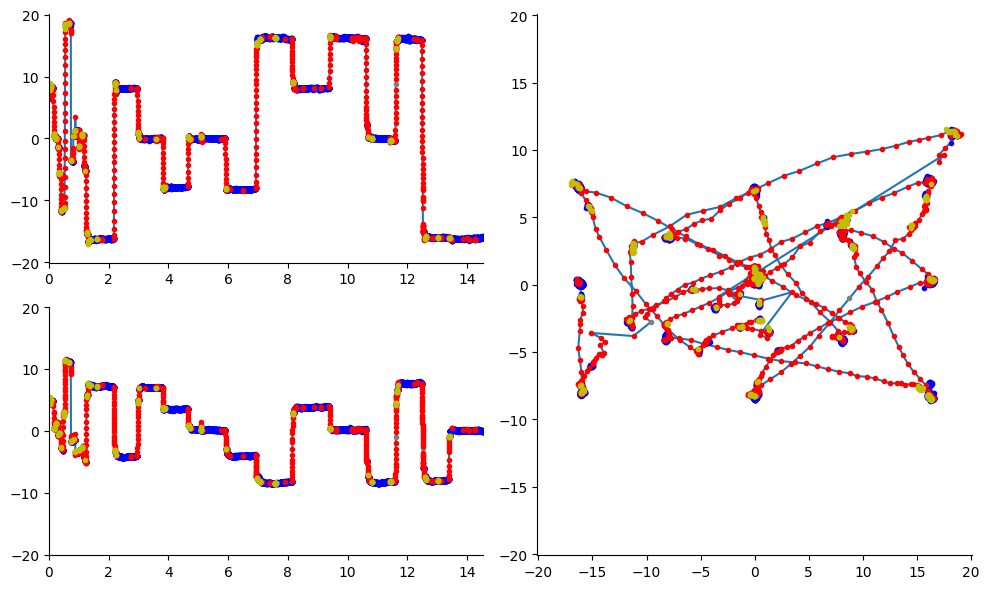

In [35]:
from utils_lib.ETeval import run_infer
import copy
import pandas as pd

# load test and run inference
test_loader = GazeDataLoader(
    test_dataset, batch_size=config['batch_size'], num_workers=0, shuffle=False)
_gt, _pr, pr_raw = run_infer(model, n_samples, test_loader, **{'eval': False})

#glue back the predictions
_data_pr = copy.deepcopy(test_dataset.data)
for _d, _pred in zip(_data_pr, pr_raw):
    _d['evt'] = 0
    _d['evt'][1:] = np.argmax(_pred, axis=1)+1
_data_pr = pd.concat([pd.DataFrame(_d) for _d in _data_pr]).reset_index(drop=True)
_data = pd.DataFrame(X_test)
_data = _data.merge(_data_pr, on='t', suffixes=('', '_pred'), how='left')
_data['evt'] = _data['evt_pred'].replace({np.nan:0})

#save
etdata_pr = ETData()
etdata_pr.load(_data[['t', 'x', 'y', 'status', 'evt']].values, **{'source':'np_array'})

# # convert back to kartesian coordinates
# X_test['x'] = X_test['x'] * px2deg + geom['display_width_pix']/2
# X_test['y'] = X_test['y'] * px2deg + geom['display_height_pix']/2

etdata_pr.plot(show=True, save=False)

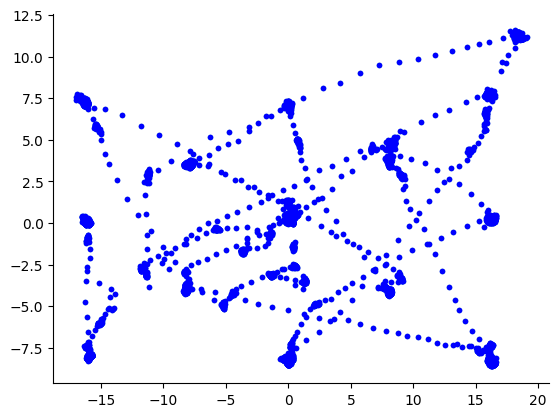

In [36]:
# %% plot
import matplotlib.pyplot as plt
import utils_lib.etdata as etdata

# plot raw data
plt.figure()
plt.plot(X_test['x'], X_test['y'], '.')

for e, c in ETData.evt_color_map.items():
    mask = X_test['evt'] == e
    plt.plot(X_test['x'][mask], X_test['y'][mask], '.', color=c)